# Custom OpenCL kernel execution in clEsperanto

The library clesperanto contains a function `execute` which is the method that is used to execute a kernel code on the GPU. If we look at its signature, it takes the following inputs:
- `anchor`: a reference starting path
- `opencl_kernel_filename`: an OpenCL kernel file which will be loaded
- `kernel_name`: the name of the kernel function to be executed inside the kernel file (usually the same as the filename)
- `global_size`: the working space of the kernel, usually the size of the image to be processed BUT not always
- `parameters`: a `dict` of parameters as `{key, variable}` to be passed to the kernel function

In [1]:
import pyclesperanto_prototype as cle
import numpy as np
from skimage.data import cells3d
from IPython.display import Markdown
import stackview
cle.select_device('TX')

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

First we need an example image. Note, this is a 3D image.

StackViewNDArray([[[5311, 4458, 5880, ..., 4220, 6497, 4932],
                   [4078, 4552, 3557, ..., 4552, 4884, 5169],
                   [3414, 5074, 4363, ..., 4078, 6117, 5406],
                   ...,
                   [3983, 3983, 2750, ..., 4410, 4600, 5880],
                   [3604, 4173, 4600, ..., 5548, 5690, 4268],
                   [4078, 4268, 4220, ..., 5359, 6686, 7492]],

                  [[4220, 4932, 5074, ..., 6449, 6117, 4932],
                   [3082, 4979, 4505, ..., 4505, 6971, 5880],
                   [4695, 4315, 4695, ..., 4742, 5785, 5074],
                   ...,
                   [3414, 3841, 3462, ..., 5169, 4742, 5027],
                   [4173, 3319, 2798, ..., 5406, 4600, 4837],
                   [3225, 3557, 3651, ..., 5453, 5406, 4837]],

                  [[4552, 4505, 4742, ..., 4458, 4979, 4647],
                   [3367, 4268, 4647, ..., 6402, 6022, 5738],
                   [3509, 3272, 4647, ..., 5264, 4220, 6259],
                   ...,
                   [3841, 3936, 3888, ..., 4884, 5169, 4789],
                   [3604, 3225, 2798, ..., 4552, 6117, 5690],
                   [4126, 4458, 4837, ..., 5928, 6734, 5027]],

                  ...,

                  [[5121, 5833, 5738, ..., 5406, 3983, 4220],
                   [5311, 5453, 5453, ..., 5169, 5027, 4884],
                   [6544, 5121, 5264, ..., 4363, 5406, 4695],
                   ...,
                   [4884, 2324, 3130, ..., 4552, 4979, 6070],
                   [3225, 2513, 2513, ..., 4742, 3035, 2418],
                   [3272, 2798, 3888, ..., 3604, 4268, 3746]],

                  [[5359, 5928, 5738, ..., 4268, 4505, 4031],
                   [7445, 6829, 4268, ..., 4884, 5596, 3082],
                   [6497, 6544, 4932, ..., 3604, 5359, 4410],
                   ...,
                   [5833, 2703, 3367, ..., 3177, 4220, 4220],
                   [4031, 3509, 5216, ..., 4268, 3604, 4932],
                   [3557, 2987, 3936, ..., 3604, 3462, 5264]],

                  [[6402, 6781, 4789, ..., 5928, 6022, 3651],
                   [4363, 4837, 6307, ..., 4315, 3651, 4126],
                   [4979, 4695, 4742, ..., 4789, 4837, 4552],
                   ...,
                   [4078, 2513, 3035, ..., 1849, 3888, 4363],
                   [3936, 3888, 4315, ..., 5216, 4031, 5643],
                   [4173, 4505, 3794, ..., 4979, 6781, 4031]]],
                 dtype=uint16)
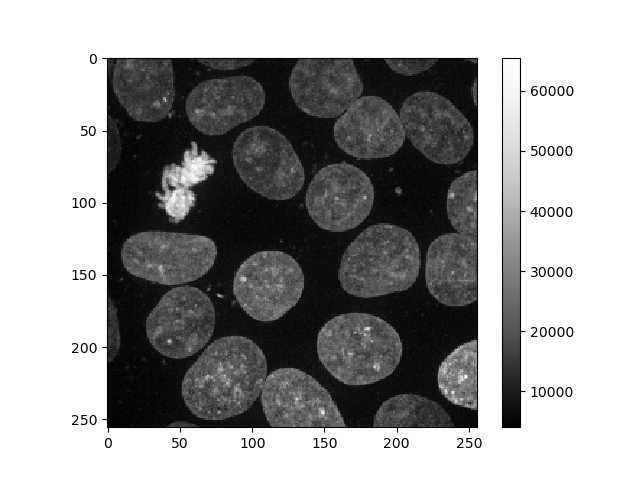
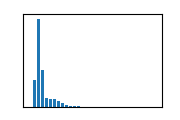

In [2]:
image = cells3d()[:,1]

stackview.insight(image)

## Custom OpenCL code
The custom OpenCL kernel code we plan to execute is stored in a text-file in the same folder.

In [3]:
opencl_filename = "maximum_z_projection.cl"

with open(opencl_filename, 'r') as file:
    opencl_file_content = file.read()

opencl_file_content = f"""
```c
{opencl_file_content}
´´´
"""
    
display(Markdown(opencl_file_content))


```c
// the sample define the GPU behaviour when accessing pixels outside of the image
__constant sampler_t sampler = CLK_NORMALIZED_COORDS_FALSE | CLK_ADDRESS_CLAMP_TO_EDGE | CLK_FILTER_NEAREST;

// the kernel function itself, with the parameters
__kernel void maximum_z_projection(
    IMAGE_src_TYPE  src,            // the input image, named 'src' 
    IMAGE_dst_TYPE  dst             // the output image, named 'dst'
) 
{
  const int x = get_global_id(0);  // the x coordinate of the current pixel, provided by the GPU thread
  const int y = get_global_id(1);  // the y coordinate of the current pixel, provided by the GPU thread

  IMAGE_src_PIXEL_TYPE max = 0;
  for (int z = 0; z < GET_IMAGE_DEPTH(src); ++z)  // loop over all z-axis range of the image
  {
    // read the pixel value at the current position (x,y,z) from the input image 'src'
    const IMAGE_src_PIXEL_TYPE value = READ_IMAGE(src, sampler, POS_src_INSTANCE(x,y,z,0)).x;  
    if (value > max || z == 0) {  // conditional statement to find the maximum value
      max = value;
    }
  }

  // write the pixel value at the current position (x,y,z) of the output image 'dst'
  WRITE_IMAGE(dst, POS_dst_INSTANCE(x,y,0,0), CONVERT_dst_PIXEL_TYPE(max));
}
´´´


## Kernel configuration
Before processing the image on the GPU, we need to reserve memory in the GPU and send the input image there. We also need to setup a dictionary with ´parameters´ that will be sent to the kernel. The working range defines how many operations the GPU is supposed to do. In our case, we plan to compute a projection image, which is a 2D version of our 3D dataset. Hence, we specify the output image's width and height as working range.

In [4]:
# Prepare the input and output memory
input_arg = cle.asarray(image)
output_arg = cle.create_like(input_arg.shape[1:]) # the z dimension is 1 because we will project into 2D along the z axis

# build the dictionary of parameters of the kernel
parameters = {'src': input_arg, 
              'dst': output_arg}

# define the path and name of the kernel file to run
opencl_kernel_filename = 'maximum_z_projection.cl' # the name of the file
kernel_name = 'maximum_z_projection'               # the name of the kernel function in the kernel file

# define the working range of the GPU
working_range = output_arg.shape

Let's run the `execute` method now

In [5]:
cle.execute("__file__", opencl_filename, kernel_name, working_range, parameters)

Notice that we do not return an output image. Here the GPU reads the input `src` and saves the results in the `dst` data, which correspond to our `output_arg` variable.

All we have to do to read it now is to pull it back to CPU memory:

In [6]:
projected = np.asarray(output_arg)
projected.shape

(256, 256)

Note that this is a 2D image now.

StackViewNDArray([[16787., 16265., 13278., ..., 15933., 16170., 15459.],
                  [18684., 15554., 13515., ..., 16739., 15601., 17640.],
                  [13847., 15838., 13135., ..., 17308., 16739., 17166.],
                  ...,
                  [ 5833.,  4505.,  4932., ...,  6876.,  6259.,  6070.],
                  [ 4505.,  4647.,  5264., ...,  5548.,  6117.,  6307.],
                  [ 4932.,  5169.,  4837., ...,  6117.,  6781.,  7492.]],
                 dtype=float32)
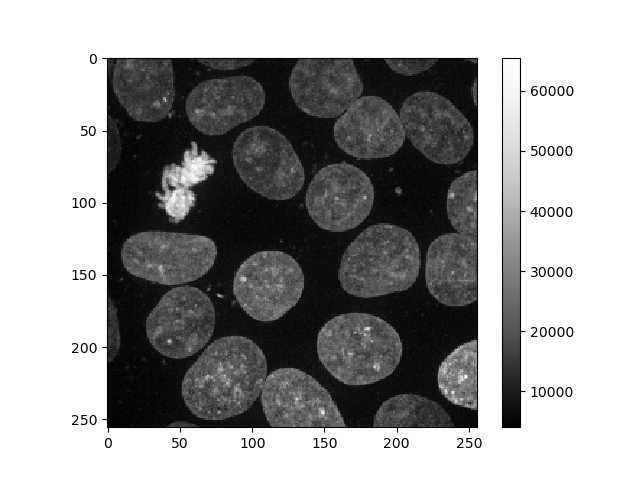
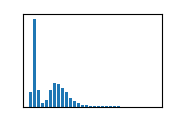

In [7]:
stackview.insight(projected)

## Sanity check
Last step, let's check that what we did is actually correct, by comparing it to the same process but on the CPU.

In [8]:
cpu_projected = image.max(axis=0)

assert np.array_equal(projected, cpu_projected)